# Evaluation of Performance

In [1]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import my_parser
import my_classifier

In [2]:
from datetime import datetime

def correct_labels(data_list):
    fixed_today = datetime(2025, 4, 1)
    
    for entry in data_list:
        expiry_date_str = entry['passport']['passport_expiry_date']
        expiry_date = datetime.strptime(expiry_date_str, "%Y-%m-%d")
        
        is_expired = expiry_date < fixed_today
        current_label = entry['label']['label']
        
        if is_expired and current_label == 'Accept':
            print(f"⚠️ Label noise in passport {entry['passport']['passport_number']}: Expired on {expiry_date_str}, but labeled 'Accept'. Correcting to 'Reject'.")
            entry['label']['label'] = 'Reject'
    
    return data_list


In [3]:
data = my_parser.get_all()

data = correct_labels(data)

⚠️ Label noise in passport EK5311807: Expired on 2024-03-04, but labeled 'Accept'. Correcting to 'Reject'.
⚠️ Label noise in passport EW1430556: Expired on 2023-06-29, but labeled 'Accept'. Correcting to 'Reject'.
⚠️ Label noise in passport EE6630802: Expired on 2022-08-04, but labeled 'Accept'. Correcting to 'Reject'.
⚠️ Label noise in passport ZX4749322: Expired on 2022-03-11, but labeled 'Accept'. Correcting to 'Reject'.
⚠️ Label noise in passport SO1857721: Expired on 2024-06-28, but labeled 'Accept'. Correcting to 'Reject'.
⚠️ Label noise in passport WY0516042: Expired on 2023-06-09, but labeled 'Accept'. Correcting to 'Reject'.
⚠️ Label noise in passport JX9971954: Expired on 2025-03-27, but labeled 'Accept'. Correcting to 'Reject'.
⚠️ Label noise in passport QL4125865: Expired on 2022-08-13, but labeled 'Accept'. Correcting to 'Reject'.
⚠️ Label noise in passport VE7667358: Expired on 2023-03-26, but labeled 'Accept'. Correcting to 'Reject'.
⚠️ Label noise in passport GN5502219:

In [4]:
use_llm = False

if use_llm:
    from vllm import LLM, SamplingParams
    llm = LLM(
        model="Qwen/Qwen2.5-72B",
        gpu_memory_utilization=0.95,
        max_model_len=16384,
        tensor_parallel_size=4,
    )
    sampling_params = SamplingParams(temperature=0.0, max_tokens=100, min_p=0.15, top_p=0.7)
else:
    llm, sampling_params = None, None

In [5]:
predictions, reasons, explanations = my_classifier.model(data, explain=True, llm=llm, sampling_params=sampling_params)

In [6]:
reasons

[[],
 [],
 [<RejectionReason.PASSPORT_LAST_NAME_SHOULD_MATCH_ACCOUNT_FORM_LAST_NAME: 3>,
  <RejectionReason.CLIENT_PROFILE_PHONE_NUMBER_SHOULD_MATCH_ACCOUNT_FORM_PHONE_NUMBER: 22>,
  <RejectionReason.PHONE_NUMBER_IN_CORRECT_FORMAT: 29>],
 [<RejectionReason.PASSPORT_FIRST_NAME_SHOULD_MATCH_ACCOUNT_FORM_FIRST_NAME: 1>,
  <RejectionReason.PASSPORT_MIDDLE_NAME_SHOULD_MATCH_ACCOUNT_FORM_MIDDLE_NAME: 2>,
  <RejectionReason.PASSPORT_LAST_NAME_SHOULD_MATCH_ACCOUNT_FORM_LAST_NAME: 3>],
 [<RejectionReason.PASSPORT_NUMBER_SHOULD_MATCH_EXTRACTED_MRZ_NUMBER: 27>],
 [],
 [<RejectionReason.UNIVERSITY_SHOULD_MATCH_DESCRIPTION: 35>],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [<RejectionReason.PASSPORT_NATIONALITY_SHOULD_MATCH_CLIENT_PROFILE_NATIONALITY: 12>,
  <RejectionReason.CLIENT_PROFILE_SECONDAY_EDUCATION_BETWEEN_SIXTEEN_TWENTYONE: 32>],
 [],
 [],
 [<RejectionReason.CLIENT_PROFILE_SECONDAY_EDUCATION_BETWEEN_SIXTEEN_TWENTYONE: 32>],
 [<RejectionReason.PASSPORT_LAST_NAME_SHOULD_MATCH_ACCOUNT_FORM_LAS

In [7]:
# Evaluate
labels = [my_classifier.label_map[item['label']['label']] for item in data]

print("📊 Classification Report:\n")
print(classification_report(labels, predictions, target_names=["Reject", "Accept"]))

print("🧮 Confusion Matrix:")
cm = confusion_matrix(y_true=labels, y_pred=predictions)
print(cm)

print("\n❌ False Positive Indices (predicted Accept, true Reject):")
false_positives = [i for i, (t, p) in enumerate(zip(labels, predictions)) if t == 0 and p == 1]
true_positives = [i for i, (t, p) in enumerate(zip(labels, predictions)) if t == 1 and p == 1]
print(false_positives)

📊 Classification Report:

              precision    recall  f1-score   support

      Reject       1.00      0.80      0.89      5150
      Accept       0.83      1.00      0.90      4850

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.92      0.90      0.90     10000

🧮 Confusion Matrix:
[[4122 1028]
 [   0 4850]]

❌ False Positive Indices (predicted Accept, true Reject):
[5, 9, 10, 12, 14, 17, 21, 31, 62, 79, 80, 86, 97, 102, 107, 118, 122, 123, 129, 151, 153, 160, 161, 182, 183, 192, 228, 245, 249, 272, 287, 293, 305, 314, 322, 330, 334, 349, 353, 354, 370, 372, 373, 374, 385, 391, 392, 406, 421, 431, 438, 513, 519, 521, 532, 535, 541, 547, 548, 578, 580, 585, 598, 600, 610, 634, 640, 656, 672, 690, 694, 697, 706, 708, 713, 723, 728, 729, 731, 749, 758, 770, 775, 788, 793, 800, 803, 805, 808, 819, 868, 892, 907, 926, 932, 955, 957, 965, 976, 977, 980, 990, 1008, 1009, 1021, 1022, 1032, 1039, 1048, 105

In [8]:
import pickle as pkl

with open('false_positives.pkl', 'wb') as f:
    pkl.dump(false_positives, f)

with open('true_positives.pkl', 'wb') as f:
    pkl.dump(true_positives, f)
    

# Explanations

In [9]:
my_classifier.explain(data)[50:60]

[(0,
  [<RejectionReason.CLIENT_PROFILE_COUNTRY_OF_DOMICILE_SHOULD_MATCH_ACCOUNT_FORM_COUNTRY_OF_DOMICILE: 18>],
  ['client_profile.country_of_domicile(Belgium) should match account_form.country_of_domicile(Belgium,France)']),
 (0,
  [<RejectionReason.PASSPORT_NATIONALITY_SHOULD_MATCH_CLIENT_PROFILE_NATIONALITY: 12>],
  ['passport.nationality(Spanish) should match client_profile.nationality(Finnish)']),
 (1, [], []),
 (0,
  [<RejectionReason.WEALTH_MUST_BE_MENTIONED: 37>],
  ['Inheritance Year must be mentioned in inheritance description']),
 (0,
  [<RejectionReason.CLIENT_PROFILE_CURRENCY_SHOULD_MATCH_ACCOUNT_FORM_CURRENCY: 24>,
   <RejectionReason.CURRENCY_SHOULD_MATCH_WEALTH_SUMMARY: 38>],
  ['client_profile.currency(AUT) should match account_form.currency(EUR)',
   "Account form currency 'AUT' should match wealth summary"]),
 (0, [<RejectionReason.PASSPORT_IS_EXPIRED: 31>], ['']),
 (0,
  [<RejectionReason.PASSPORT_ISSUE_DATE_SHOULD_MATCH_CLIENT_PROFILE_PASSPORT_ISSUE_DATE: 14>,
   

# Analyze Rules

In [10]:
# How many times did each rule fire?
N = len(data)
for rule in my_classifier.RejectionReason:
    firings = len([1 for rules in reasons if rule in rules])
    print(f"""Rule {rule.value}: {rule.name}\n    fired {firings} times, {firings/N*100:.2f}% of the time""")

Rule 1: PASSPORT_FIRST_NAME_SHOULD_MATCH_ACCOUNT_FORM_FIRST_NAME
    fired 317 times, 3.17% of the time
Rule 2: PASSPORT_MIDDLE_NAME_SHOULD_MATCH_ACCOUNT_FORM_MIDDLE_NAME
    fired 118 times, 1.18% of the time
Rule 3: PASSPORT_LAST_NAME_SHOULD_MATCH_ACCOUNT_FORM_LAST_NAME
    fired 409 times, 4.09% of the time
Rule 4: PASSPORT_NUMBER_SHOULD_MATCH_ACCOUNT_FORM_PASSPORT_NUMBER
    fired 88 times, 0.88% of the time
Rule 5: PASSPORT_NUMBER_SHOULD_MATCH_CLIENT_PROFILE_PASSPORT_NUMBER
    fired 50 times, 0.50% of the time
Rule 7: PASSPORT_BIRTH_DATE_SHOULD_MATCH_CLIENT_PROFILE_BIRTH_DATE
    fired 266 times, 2.66% of the time
Rule 10: PASSPORT_GENDER_SHOULD_MATCH_CLIENT_PROFILE_GENDER
    fired 76 times, 0.76% of the time
Rule 12: PASSPORT_NATIONALITY_SHOULD_MATCH_CLIENT_PROFILE_NATIONALITY
    fired 205 times, 2.05% of the time
Rule 14: PASSPORT_ISSUE_DATE_SHOULD_MATCH_CLIENT_PROFILE_PASSPORT_ISSUE_DATE
    fired 203 times, 2.03% of the time
Rule 16: PASSPORT_EXPIRY_DATE_SHOULD_MATCH_CLIENT

In [11]:
# How many times was each rule decisive?
for rule in my_classifier.RejectionReason:
    decisive = len([1 for rules in reasons if (rule in rules and len(rules) == 1)])
    print(f"""Rule {rule.value}: {rule.name}\n    decisive {decisive} times, {decisive/N*100:.2f}% of the time""")

Rule 1: PASSPORT_FIRST_NAME_SHOULD_MATCH_ACCOUNT_FORM_FIRST_NAME
    decisive 43 times, 0.43% of the time
Rule 2: PASSPORT_MIDDLE_NAME_SHOULD_MATCH_ACCOUNT_FORM_MIDDLE_NAME
    decisive 4 times, 0.04% of the time
Rule 3: PASSPORT_LAST_NAME_SHOULD_MATCH_ACCOUNT_FORM_LAST_NAME
    decisive 123 times, 1.23% of the time
Rule 4: PASSPORT_NUMBER_SHOULD_MATCH_ACCOUNT_FORM_PASSPORT_NUMBER
    decisive 14 times, 0.14% of the time
Rule 5: PASSPORT_NUMBER_SHOULD_MATCH_CLIENT_PROFILE_PASSPORT_NUMBER
    decisive 6 times, 0.06% of the time
Rule 7: PASSPORT_BIRTH_DATE_SHOULD_MATCH_CLIENT_PROFILE_BIRTH_DATE
    decisive 72 times, 0.72% of the time
Rule 10: PASSPORT_GENDER_SHOULD_MATCH_CLIENT_PROFILE_GENDER
    decisive 0 times, 0.00% of the time
Rule 12: PASSPORT_NATIONALITY_SHOULD_MATCH_CLIENT_PROFILE_NATIONALITY
    decisive 83 times, 0.83% of the time
Rule 14: PASSPORT_ISSUE_DATE_SHOULD_MATCH_CLIENT_PROFILE_PASSPORT_ISSUE_DATE
    decisive 0 times, 0.00% of the time
Rule 16: PASSPORT_EXPIRY_DATE_S

In [12]:
# Correlation between rules
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from enum import Enum
from typing import List

def plot_enum_cooccurrence_matrix(enum_lists: List[List[Enum]], title: str = "Co-occurrence Matrix") -> None:
    if not enum_lists or not any(enum_lists):
        print("Empty input data.")
        return

    enum_members = list(my_classifier.RejectionReason)
    index_map = {reason: idx for idx, reason in enumerate(enum_members)}
    n = len(enum_members)
    matrix = np.zeros((n, n), dtype=int)

    # Count co-occurrences
    for sublist in enum_lists:
        for e1, e2 in combinations(sublist, 2):
            i, j = index_map[e1], index_map[e2]
            matrix[i, j] += 1
            matrix[j, i] += 1
        for e in sublist:
            i = index_map[e]
            matrix[i, i] += 1

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=[e.value for e in enum_members],
                yticklabels=[e.value for e in enum_members])
    plt.title(title)
    plt.tight_layout()
    plt.show()

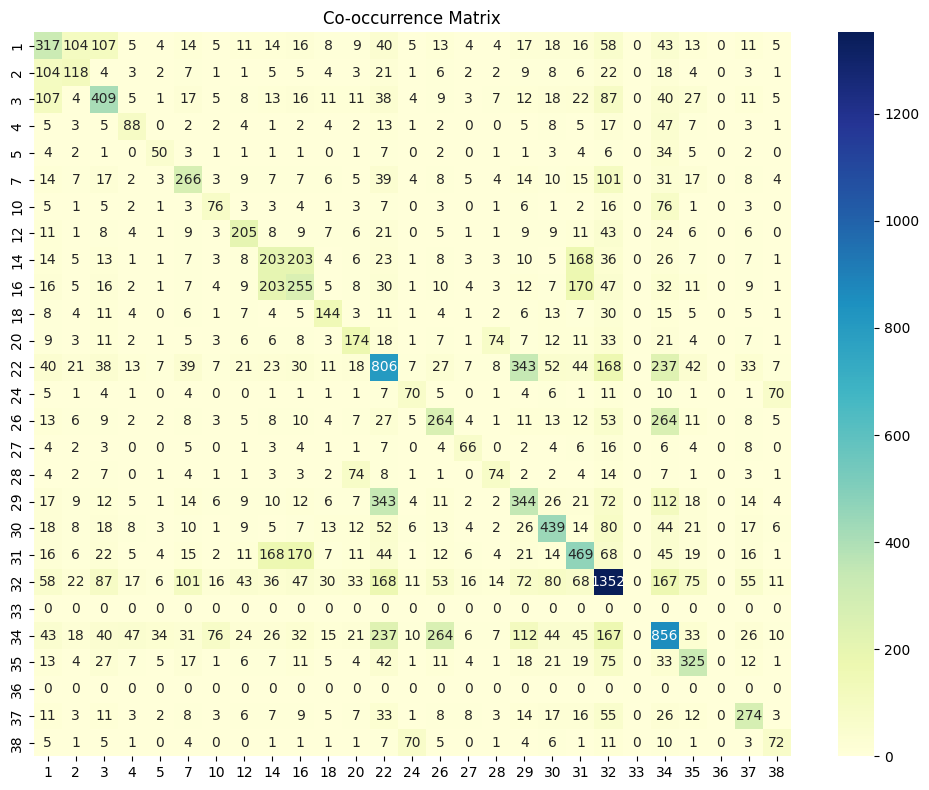

In [13]:
plot_enum_cooccurrence_matrix(reasons)

# Export to Solution.csv

In [14]:
my_parser.export(predictions, "Based_Bayes.csv")